In [1]:
import os
import tensorflow as tf
import glob
import tqdm
import lucid.optvis.render as render
import lucid.modelzoo.vision_models as models
from keras.applications.inception_v3 import preprocess_input
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# Import InceptionV1 model
model = models.InceptionV1()
model.load_graphdef()

In [4]:
def _parse_function(feature_proto, image_size=224):
    '''
    Parse imagenet data in tf-record format
    * input
        - feature_proto: feature prototype
        - image_size: the image size (width or height)
        - with_input
    * output
        - image: parsed images
        - label: parsed labels of the images
        - synset: parsed synset
    '''

    # Parse bytes features
    def _bytes_feature(value):
        return tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[value]))

    # Parse int64 features
    def _int64_feature(value):
        return tf.train.Feature(
            int64_list=tf.train.Int64List(value=[value]))

    # Features to get from the dataset
    feature_set = {
        'image/encoded': tf.FixedLenFeature([], tf.string),
        'image/class/label': tf.FixedLenFeature([], tf.int64),
        'image/class/synset': tf.FixedLenFeature([], tf.string)
    }

    # Parse features
    parsed_features = tf.parse_single_example(feature_proto, feature_set)

    # Get each parsed feature
    image = parsed_features['image/encoded']
    label = parsed_features['image/class/label']
    synset = parsed_features['image/class/synset']

    # Decode images
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(
        image, 
        tf.constant([image_size, image_size])
    )

    return image, label, synset

In [5]:
dir_path = '../../data/tfrec'
synsets = ['n02391049', 'n01537544', 'n03837869']
input_path = ['{}/train-{}.tfrec'.format(dir_path, s) for s in synsets]

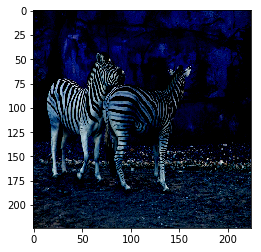

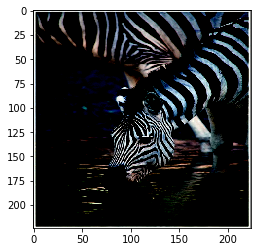

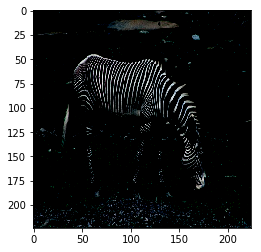

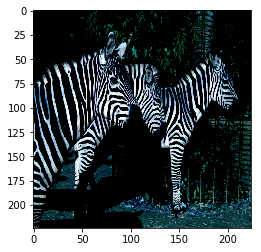

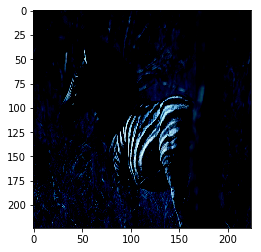

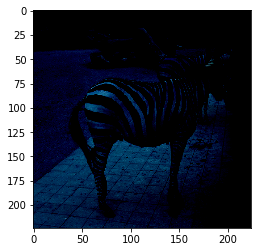

In [ ]:
batch_size = 20
with tf.Graph().as_default():
    
    # Parse datasets of a certain batch size
    dataset = tf.data.TFRecordDataset(input_path)
    dataset = dataset.map(_parse_function)
    dataset = dataset.map(
        lambda img, lab, syn: (preprocess_input(img), lab, syn)
    )
    dataset = dataset.batch(batch_size)

    # Define dataset iterator
    iterator = dataset.make_one_shot_iterator()

    # Define tensors to store the dataset
    t_preprocessed_images, t_labels, t_synsets = iterator.get_next()

    # Define actiavtion map render
    T = render.import_model(model, t_preprocessed_images, None)
    T('mixed3a')
    
    tensors = t_preprocessed_images
    
    with tf.Session() as sess:
        try:
            while(True):
                sess_data = sess.run(tensors)
                plt.imshow(sess_data[0, :, :])
                plt.show()
#                 print(sess_data.shape)
        except tf.errors.OutOfRangeError:
            pass